# Importing Libraries

In [1]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date
import holidays

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Data

In [3]:
data = pd.read_csv('/content/drive/MyDrive/rnn_dataset.csv')
data.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [4]:
data = data.set_index(['Datetime'])
data.index = pd.to_datetime(data.index)
data_3 = data.sort_index()

#  Part 1: where we use the previous 100 values as the features

In [5]:
data_1 = pd.DataFrame()

for i in range(100, 0, -1):
    data_1[f'previous_{i}_value'] = data_3['PJMW_MW'].shift(i)

data_1['Y'] = data_3['PJMW_MW']

data_1 = data_1.dropna()

In [6]:
data_1.head()

,previous_100_value,previous_99_value,previous_98_value,previous_97_value,previous_96_value,previous_95_value,previous_94_value,previous_93_value,previous_92_value,previous_91_value,...,previous_9_value,previous_8_value,previous_7_value,previous_6_value,previous_5_value,previous_4_value,previous_3_value,previous_2_value,previous_1_value,Y
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-04-05 05:00:00,4374.0,4306.0,4322.0,4359.0,4436.0,4723.0,5180.0,5482.0,5616.0,5722.0,...,6254.0,6245.0,6053.0,5634.0,5266.0,5140.0,5045.0,5027.0,5062.0,5172.0
2002-04-05 06:00:00,4306.0,4322.0,4359.0,4436.0,4723.0,5180.0,5482.0,5616.0,5722.0,5783.0,...,6245.0,6053.0,5634.0,5266.0,5140.0,5045.0,5027.0,5062.0,5172.0,5516.0
2002-04-05 07:00:00,4322.0,4359.0,4436.0,4723.0,5180.0,5482.0,5616.0,5722.0,5783.0,5683.0,...,6053.0,5634.0,5266.0,5140.0,5045.0,5027.0,5062.0,5172.0,5516.0,5962.0
2002-04-05 08:00:00,4359.0,4436.0,4723.0,5180.0,5482.0,5616.0,5722.0,5783.0,5683.0,5637.0,...,5634.0,5266.0,5140.0,5045.0,5027.0,5062.0,5172.0,5516.0,5962.0,6240.0
2002-04-05 09:00:00,4436.0,4723.0,5180.0,5482.0,5616.0,5722.0,5783.0,5683.0,5637.0,5571.0,...,5266.0,5140.0,5045.0,5027.0,5062.0,5172.0,5516.0,5962.0,6240.0,6113.0


In [7]:
data_1_norm = (data_1-data_1.mean())/data_1.std()

# Train-Validation-Test split

In [8]:
X = data_1_norm.drop(columns = ['Y'])
y = data_1_norm['Y']

y_mean = data_1['Y'].mean()
y_std = data_1['Y'].std()

In [9]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_cv, y_cv, test_size=0.5, shuffle=False)

In [49]:
batch_size = 16

train_features = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_targets = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
val_features = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_targets = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
test_features = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_targets = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=len(X_test), shuffle=False, drop_last=True)

# RNN Model

In [11]:
class RNN_part1(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(RNN_part1, self).__init__()

        self.hidden_size = hidden_size
        self.layer_size = layer_size

        
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = torch.zeros(self.layer_size, self.hidden_size).requires_grad_().to(device)
        o, h = self.rnn(x, h)
        out = self.fc(o)
        return out

In [12]:
input_size = len(X_train.columns)
output_size = 1
hidden_size = 8
layer_size = 8

n_epochs = 100
learning_rate = 3e-3

In [13]:
model_1 = RNN_part1(input_size, hidden_size, layer_size, output_size).to(device)

In [14]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model_1.parameters(), lr=learning_rate)

# Training the model

In [15]:
loss_train = []
loss_val = []
n_iter = []

for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for data in train_loader:
        X, truth = data
        X, truth = X.to(device), truth.to(device)
        predictions = model_1(X)
        loss = loss_fn(predictions, truth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    for data in val_loader:
        X, truth = data
        X, truth = X.to(device), truth.to(device)
        predictions = model_1(X)
        loss = loss_fn(predictions, truth)
        val_loss += loss.item()
        
    if epoch%(n_epochs//10)==0 or epoch == n_epochs-1 or epoch == 1:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, n_epochs, running_loss/(len(X_train)//batch_size+1), val_loss/(len(X_val)//batch_size+1)))
        loss_train.append(running_loss/(len(X_train)//batch_size+1))
        loss_val.append(val_loss/(len(X_val)//batch_size+1))
        n_iter.append(epoch)

Epoch [1/100], Train Loss: 0.6203, Val Loss: 0.7945
Epoch [10/100], Train Loss: 0.4024, Val Loss: 0.5200
Epoch [20/100], Train Loss: 0.3950, Val Loss: 0.4860
Epoch [30/100], Train Loss: 0.3919, Val Loss: 0.4724
Epoch [40/100], Train Loss: 0.3900, Val Loss: 0.4662
Epoch [50/100], Train Loss: 0.3888, Val Loss: 0.4598
Epoch [60/100], Train Loss: 0.3880, Val Loss: 0.4557
Epoch [70/100], Train Loss: 0.3874, Val Loss: 0.4523
Epoch [80/100], Train Loss: 0.3870, Val Loss: 0.4494
Epoch [90/100], Train Loss: 0.3866, Val Loss: 0.4468
Epoch [99/100], Train Loss: 0.3863, Val Loss: 0.4447
Epoch [100/100], Train Loss: 0.3863, Val Loss: 0.4444


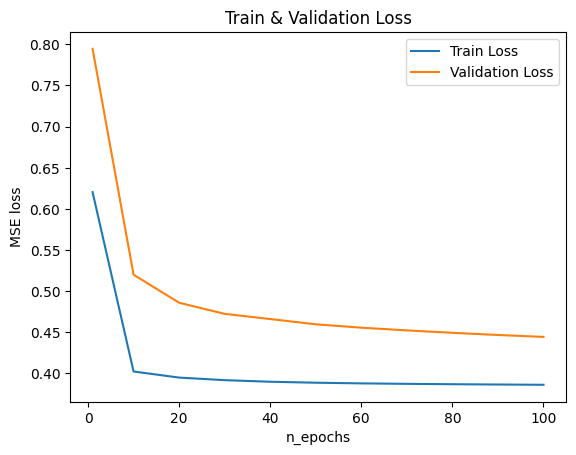

In [16]:
plt.plot(n_iter, loss_train)
plt.plot(n_iter, loss_val)
plt.legend(['Train Loss', 'Validation Loss'])
plt.ylabel('MSE loss')
plt.xlabel('n_epochs')
plt.title('Train & Validation Loss')
plt.show()

# Model Evaluation

In [ ]:
for data in test_loader:
    X, truth = data
    X, truth = X.to(device), truth.to(device)
    predictions = model_1(X)
    predictions = predictions.cpu().detach().numpy()
    truth = truth.cpu().detach().numpy()
    predictions = predictions*y_std + y_mean
    truth = truth*y_std + y_mean

In [59]:
print('MSE:', mean_squared_error(truth, predictions))
print('RMSE:', mean_absolute_error(truth, predictions))
print('R2 score:',r2_score(truth, predictions))

MSE: 14268.327101125
RMSE: 389.48028027343753
R2 score: 0.7219463833151696


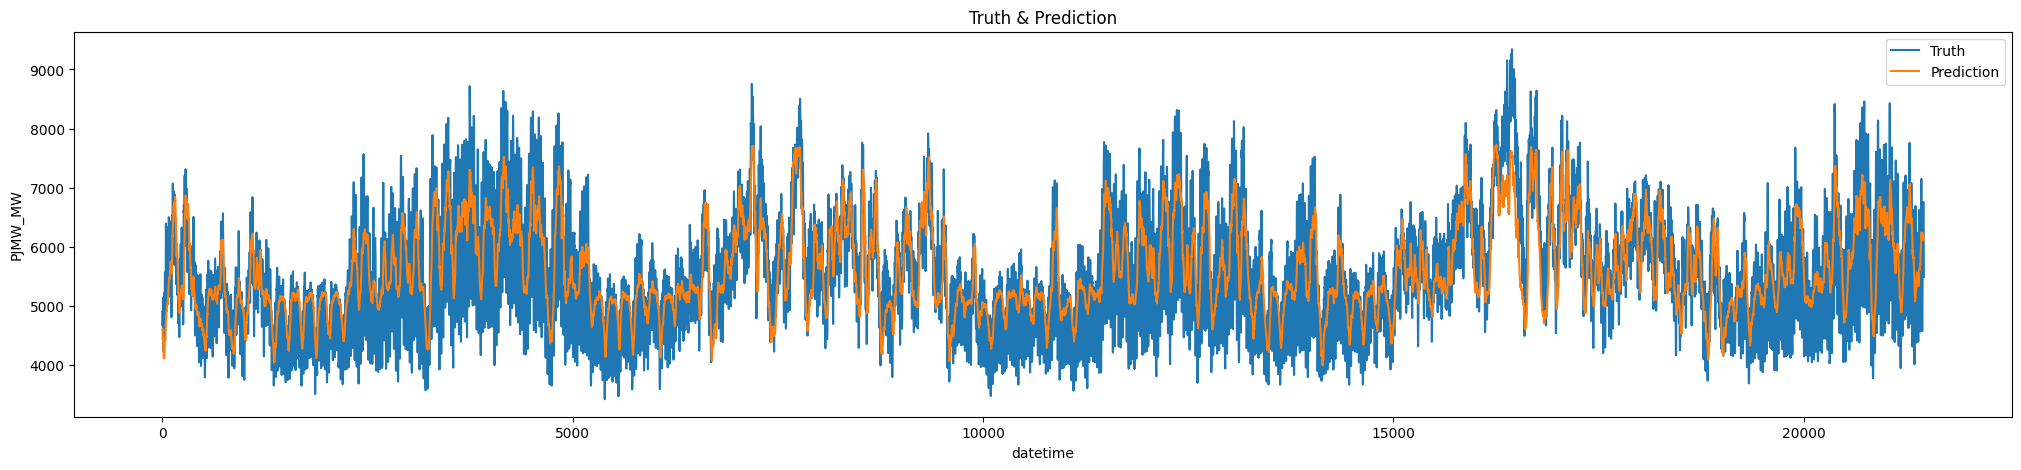

In [19]:
plt.figure(figsize=(25, 5))
plt.plot(truth)
plt.plot(predictions)

plt.legend(['Truth', 'Prediction'])
plt.ylabel('PJMW_MW')
plt.xlabel('datetime')
plt.title('Truth & Prediction')
plt.show()

- We can observe that our model has captured and expained the variance in the dataset.

# Part 2: where we use the date, time, week & year as the features

In [20]:
data = pd.read_csv('/content/drive/MyDrive/rnn_dataset.csv')
data.head()

data = data.set_index(['Datetime'])
data.index = pd.to_datetime(data.index)
data_2 = data.sort_index()

### Getting date & time features and One-Hot Encoding

In [21]:
data_2 = (data_2.assign(hour = data_2.index.hour).assign(day = data_2.index.day).assign(month = data_2.index.month).assign(day_of_week = data_2.index.dayofweek).assign(week_of_year = data_2.index.week))

In [22]:
data_2.head()

,PJMW_MW,hour,day,month,day_of_week,week_of_year
Datetime,,,,,,
2002-04-01 01:00:00,4374.0,1,1,4,0,14
2002-04-01 02:00:00,4306.0,2,1,4,0,14
2002-04-01 03:00:00,4322.0,3,1,4,0,14
2002-04-01 04:00:00,4359.0,4,1,4,0,14
2002-04-01 05:00:00,4436.0,5,1,4,0,14


In [23]:
for i in ['month','day','day_of_week','week_of_year']:    
    one_hot = pd.get_dummies(data_2[i], prefix=i)
    data_2 = pd.concat([data_2, one_hot], axis=1)
    data_2 = data_2.drop(i, axis=1)

### Holidays as a feature

In [24]:
indian_holidays = holidays.IN()

def is_indian_holiday(date):
    date = date.replace(hour = 0)
    if (date in indian_holidays) :
        return 1
    else :
        return 0

In [25]:
data_2 = data_2.assign(is_indian_holiday = data_2.index.to_series().apply(is_indian_holiday))

### Accounting Periodicity of hour
- when we thing about periodicity, the most obvious thing is sinusoidal and cosine transforms

In [26]:
data_2['hour_sine'] = np.sin(2 * np.pi * data_2['hour']/24.0)
data_2['hour_cosine'] = np.cos(2 * np.pi * data_2['hour']/24.0)
data_2 = data_2.drop('hour', axis=1)

- When we do sine and cosine transform, the distance between (22:00, 23:00) and (24:00, 01:00) becomes the same, as depicted :

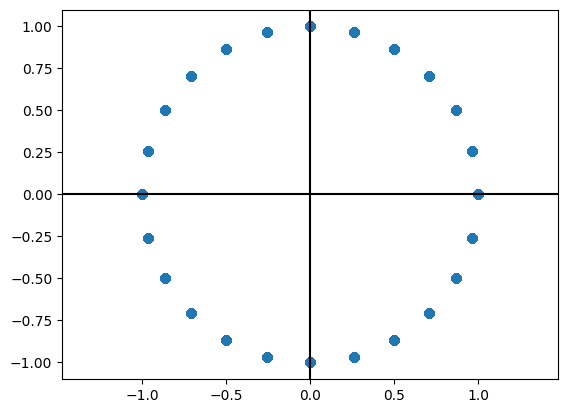

In [27]:
plt.scatter(data_2['hour_sine'], data_2['hour_cosine'])
plt.axis('equal')
plt.axvline(x=0, c="black")
plt.axhline(y=0, c="black")
plt.show()

In [28]:
data_2.head(2)

,PJMW_MW,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,is_indian_holiday,hour_sine,hour_cosine
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-04-01 01:00:00,4374.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.258819,0.965926
2002-04-01 02:00:00,4306.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.500000,0.866025


In [29]:
data_2_norm = (data_2-data_2.mean())/data_2.std()

# Train-Validation-Test split

In [30]:
X = data_2_norm.drop(columns = ['PJMW_MW'])
y = data_2_norm['PJMW_MW']

y_mean_2 = data_2['PJMW_MW'].mean()
y_std_2 = data_2['PJMW_MW'].std()

In [31]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_cv, y_cv, test_size=0.5, shuffle=False)

In [53]:
batch_size = 8

train_features = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_targets = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
val_features = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_targets = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
test_features = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_targets = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=len(X_test), shuffle=False, drop_last=True)

# Training RNN Model Part - 2

In [33]:
input_size = len(X_train.columns)
output_size = 1
hidden_size = 8
layer_size = 8

n_epochs = 100
learning_rate = 2e-3

In [34]:
model_2 = RNN_part1(input_size, hidden_size, layer_size, output_size).to(device)

In [35]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model_2.parameters(), lr=learning_rate)

In [36]:
loss_train = []
loss_val = []
n_iter = []

for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for data in train_loader:
        X, truth = data
        X, truth = X.to(device), truth.to(device)
        predictions = model_2(X)
        loss = loss_fn(predictions, truth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    for data in val_loader:
        X, truth = data
        X, truth = X.to(device), truth.to(device)
        predictions = model_2(X)
        loss = loss_fn(predictions, truth)
        val_loss += loss.item()
        
    if epoch%(n_epochs//10)==0 or epoch == n_epochs-1 or epoch == 1:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, n_epochs, running_loss/(len(X_train)//batch_size+1), val_loss/(len(X_val)//batch_size+1)))
        loss_train.append(running_loss/(len(X_train)//batch_size+1))
        loss_val.append(val_loss/(len(X_val)//batch_size+1))
        n_iter.append(epoch)

Epoch [1/100], Train Loss: 0.7712, Val Loss: 1.2039
Epoch [10/100], Train Loss: 0.3293, Val Loss: 0.6362
Epoch [20/100], Train Loss: 0.3190, Val Loss: 0.6379
Epoch [30/100], Train Loss: 0.3159, Val Loss: 0.6272
Epoch [40/100], Train Loss: 0.3145, Val Loss: 0.6410
Epoch [50/100], Train Loss: 0.3141, Val Loss: 0.6443
Epoch [60/100], Train Loss: 0.3143, Val Loss: 0.6420
Epoch [70/100], Train Loss: 0.3096, Val Loss: 0.6712
Epoch [80/100], Train Loss: 0.3045, Val Loss: 0.6630
Epoch [90/100], Train Loss: 0.3071, Val Loss: 0.6524
Epoch [99/100], Train Loss: 0.3085, Val Loss: 0.6559
Epoch [100/100], Train Loss: 0.3088, Val Loss: 0.6562


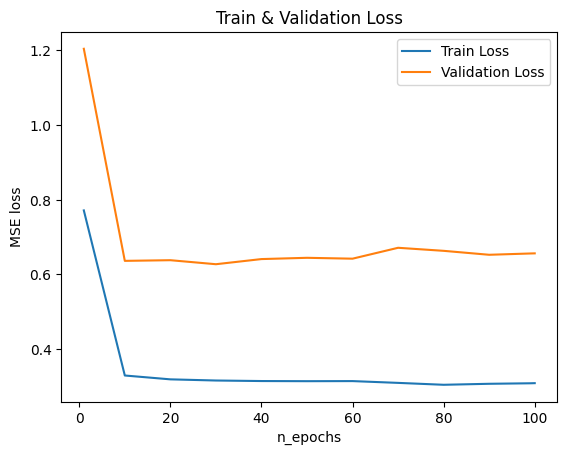

In [41]:
plt.plot(n_iter, loss_train)
plt.plot(n_iter, loss_val)
plt.legend(['Train Loss', 'Validation Loss'])
plt.ylabel('MSE loss')
plt.xlabel('n_epochs')
plt.title('Train & Validation Loss')
plt.show()

# Model Evaluation

In [54]:
for data in test_loader:
    X, truth = data
    X, truth = X.to(device), truth.to(device)
    predictions = model_2(X)
    predictions = predictions.cpu().detach().numpy()
    truth = truth.cpu().detach().numpy()
    predictions = predictions*y_std_2 + y_mean_2
    truth = truth*y_std_2 + y_mean_2

In [55]:
print('MSE:', mean_squared_error(truth, predictions))
print('RMSE:', mean_absolute_error(truth, predictions))
print('R2 score:',r2_score(truth, predictions))

MSE: 21631.011824999998
RMSE: 537.2141796875001
R2 score: 0.6710775324582742


### Comparison of the two models
- Using the previous 100 values of the target as features is the first approach. This approach is very effective for time-series forecasting problems like the current one, where the current value of the target is highly dependent on its past values. However, this approach can be limited by the struggle to capture changes in the underlying patterns over time.
- Using the date and time of recording the target as features can be useful for capturing patterns that are related to external factors such as seasonality or business cycles.
- In our case, using the previous 100 values as features worked better.

$$
Thank You
$$